In [1]:

import pandas as pd
import numpy as np
import pickle
from datetime import datetime

import sys
sys.path.insert(0, "..")   
from src.model_utils import train
from src.plot_util import plot_all_sids_losses, plot_loss_per_sid, plot_median_iqr_loss



In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
today_str = datetime.today().strftime("%Y-%m-%d")
today_str

'2025-05-30'

In [4]:
# load
df = pd.read_excel("../output/data/20250530_scaled_train_top_10_store_10_item_sales_cyclical_features_16_days_X_y.xlsx")
#df = pd.read_excel("../output/data/scaled_train_3_114790_sales_cyclical_features_16_days_X_y.xlsx")
df.head()

,start_date,store_item,store,item,sales_day_1,sales_day_2,sales_day_3,sales_day_4,sales_day_5,sales_day_6,...,y_monthofyear_cos_7,y_monthofyear_cos_8,y_monthofyear_cos_9,y_monthofyear_cos_10,y_monthofyear_cos_11,y_monthofyear_cos_12,y_monthofyear_cos_13,y_monthofyear_cos_14,y_monthofyear_cos_15,y_monthofyear_cos_16
0,2013-01-09,3_1047679,3,1047679,0.326480,0.129257,0.457841,0.563467,0.169148,0.289882,...,0.933013,0.75,0.75,0.75,0.75,0.75,0.75,0.75,0.75,0.75
1,2013-01-25,3_1047679,3,1047679,0.183388,0.129257,0.399663,0.155418,0.065156,0.178771,...,0.750000,0.75,0.75,0.75,0.75,0.75,0.75,0.75,0.75,0.75
2,2013-02-10,3_1047679,3,1047679,0.200658,0.076560,0.204890,0.177090,0.049838,0.165736,...,0.500000,0.50,0.50,0.50,0.50,0.50,0.50,0.50,0.50,0.50
3,2013-02-26,3_1047679,3,1047679,0.141447,0.087497,0.194772,0.180805,0.113269,0.456859,...,0.500000,0.50,0.50,0.50,0.50,0.50,0.50,0.50,0.50,0.50
4,2013-03-14,3_1047679,3,1047679,0.351974,0.104151,0.424958,0.385759,0.063215,0.155183,...,0.250000,0.25,0.25,0.25,0.25,0.25,0.25,0.25,0.25,0.25


In [5]:
df["start_date"].min(), df["start_date"].max()

(Timestamp('2013-01-09 00:00:00'), Timestamp('2017-07-15 00:00:00'))

In [6]:
df.dtypes

start_date              datetime64[ns]
store_item                      object
store                            int64
item                             int64
sales_day_1                    float64
                             ...      
y_monthofyear_cos_12           float64
y_monthofyear_cos_13           float64
y_monthofyear_cos_14           float64
y_monthofyear_cos_15           float64
y_monthofyear_cos_16           float64
Length: 292, dtype: object

In [7]:
df.columns

Index(['start_date', 'store_item', 'store', 'item', 'sales_day_1',
       'sales_day_2', 'sales_day_3', 'sales_day_4', 'sales_day_5',
       'sales_day_6',
       ...
       'y_monthofyear_cos_7', 'y_monthofyear_cos_8', 'y_monthofyear_cos_9',
       'y_monthofyear_cos_10', 'y_monthofyear_cos_11', 'y_monthofyear_cos_12',
       'y_monthofyear_cos_13', 'y_monthofyear_cos_14', 'y_monthofyear_cos_15',
       'y_monthofyear_cos_16'],
      dtype='object', length=292)

In [8]:
df.shape

(10386, 292)

In [22]:
window_size = 16

cyclical_features = (
    [f"dayofweek_sin_{i}" for i in range(1, window_size + 1)] +
    [f"dayofweek_cos_{i}" for i in range(1, window_size + 1)] +
    [f"weekofmonth_sin_{i}" for i in range(1, window_size + 1)] +
    [f"weekofmonth_cos_{i}" for i in range(1, window_size + 1)] +
    [f"monthofyear_sin_{i}" for i in range(1, window_size + 1)] +
    [f"monthofyear_cos_{i}" for i in range(1, window_size + 1)]
)

sales_features = (
    [f"sales_day_{i}" for i in range(1, window_size + 1)] +
    [f"store_med_day_{i}" for i in range(1, window_size + 1)] +
    [f"item_med_day_{i}" for i in range(1, window_size + 1)]
)

feature_cols = sales_features + cyclical_features
label_cols = [f"y_{c}" for c in feature_cols]
y_sales_features = [f"y_{c}" for c in sales_features]
y_cyclical_features = [f"y_{c}" for c in cyclical_features]


In [23]:
print(len(feature_cols))
print(len(label_cols))


144
144


In [24]:
# … shift & drop to build X, y …
# train_df = df.dropna(subset=[f'y_{c}' for c in feature_cols]).reset_index(drop=True)
# train_df.head()

In [25]:
weights_df= pd.read_excel("../output/data/top_10_item_weights.xlsx")

In [26]:
weights_df

,item,weight
0,114790,1.00
1,305229,1.00
2,314384,1.00
3,364606,1.00
4,502331,1.25
5,567623,1.00
6,581078,1.00
7,582864,1.25
8,584028,1.25
9,1047679,1.00


In [27]:
# with open('../output/data/3_114790_minmax_X_scaler.pkl', 'rb') as f:
#     X_scaler = pickle.load(f)
with open('../output/data/20250530_top10_store_10_item_minmax_y_scaler.pkl', 'rb') as f:
#with open('../output/data/3_114790_minmax_y_scaler.pkl', 'rb') as f:
    y_scaler = pickle.load(f)

In [29]:
hist_df, summary_df, models_dict = train(
    df            = df,
    y_scaler       = y_scaler,
    weights_df    = weights_df,
    feature_cols  = feature_cols,
    label_cols    = label_cols,
    y_sales_features = y_sales_features,
    item_col      = "item",
    train_frac    = 0.8,
    batch_size    = 32,
    lr            = 1e-3,
    epochs        = 100,
    seed          = 2025,
    model_dir     = "../output/models/"
)

[3_1047679] Epoch 1/100 train_RMSLE 2.8449, train_MAE 59.1222, test_RMSLE 2.7612, test_MAE 49.5891
[3_1047679] Epoch 2/100 train_RMSLE 2.7642, train_MAE 56.8905, test_RMSLE 2.6948, test_MAE 47.3788
[3_1047679] Epoch 3/100 train_RMSLE 2.6953, train_MAE 53.9210, test_RMSLE 2.6344, test_MAE 44.4915
[3_1047679] Epoch 4/100 train_RMSLE 2.6317, train_MAE 50.2626, test_RMSLE 2.5779, test_MAE 41.1765
[3_1047679] Epoch 5/100 train_RMSLE 2.5723, train_MAE 46.4677, test_RMSLE 2.5263, test_MAE 37.9220
[3_1047679] Epoch 6/100 train_RMSLE 2.5182, train_MAE 42.9818, test_RMSLE 2.4805, test_MAE 34.8371
[3_1047679] Epoch 7/100 train_RMSLE 2.4701, train_MAE 39.7788, test_RMSLE 2.4396, test_MAE 32.0031
[3_1047679] Epoch 8/100 train_RMSLE 2.4268, train_MAE 36.9296, test_RMSLE 2.4010, test_MAE 29.6451
[3_1047679] Epoch 9/100 train_RMSLE 2.3856, train_MAE 34.5767, test_RMSLE 2.3619, test_MAE 27.8840
[3_1047679] Epoch 10/100 train_RMSLE 2.3437, train_MAE 32.8772, test_RMSLE 2.3205, test_MAE 26.7655
[3_104767

In [30]:
hist_df.head(3)


,store_item,epoch,train_loss,train_mae,test_loss,test_mae
0,3_1047679,1,2.844879,59.122155,2.761184,49.589141
1,3_1047679,2,2.764221,56.890490,2.694790,47.378772
2,3_1047679,3,2.695297,53.921028,2.634355,44.491485


In [31]:
summary_df.head(3)

,store_item,final_train_loss,final_test_loss
0,3_1047679,0.714740,0.981537
1,3_114790,0.697988,0.973993
2,3_305229,0.702843,0.934243


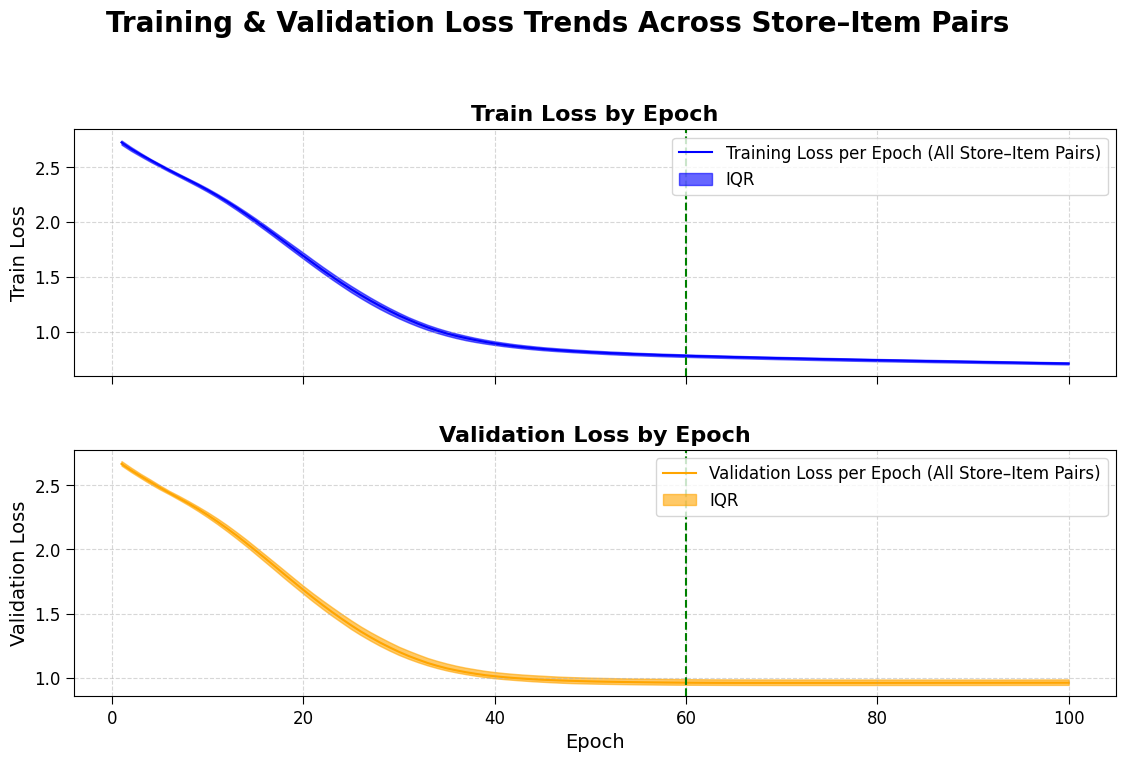

In [32]:
# plot_all_sids_losses(hist_df, 
#                      overall_title="Loss Curves for All Store Items",
# fn=f"../output/figures/all_sids_loss_curves_{today_str}.tiff")
plot_median_iqr_loss(hist_df, 
                     overall_title="Training & Validation Loss Trends Across Store–Item Pairs",
                     xvline=60,
fn=f"../output/figures/median_iqr_loss_curves_{today_str}.tiff")


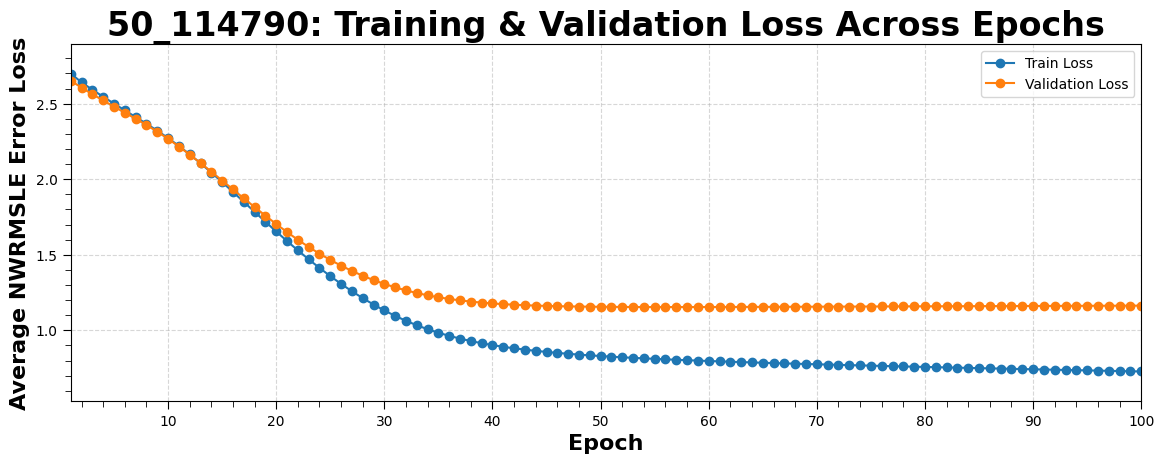

In [33]:
# to plot a single sid:
sid = "50_114790"
title = f"{sid}: Training & Validation Loss Across Epochs"
plot_loss_per_sid(hist_df, title = title,  
                  sid=sid, fn=f"../output/figures/loss_curves_{sid}_{today_str}.tiff",
                  train_col="train_loss", test_col="test_loss", y_label="Average NWRMSLE Error Loss")

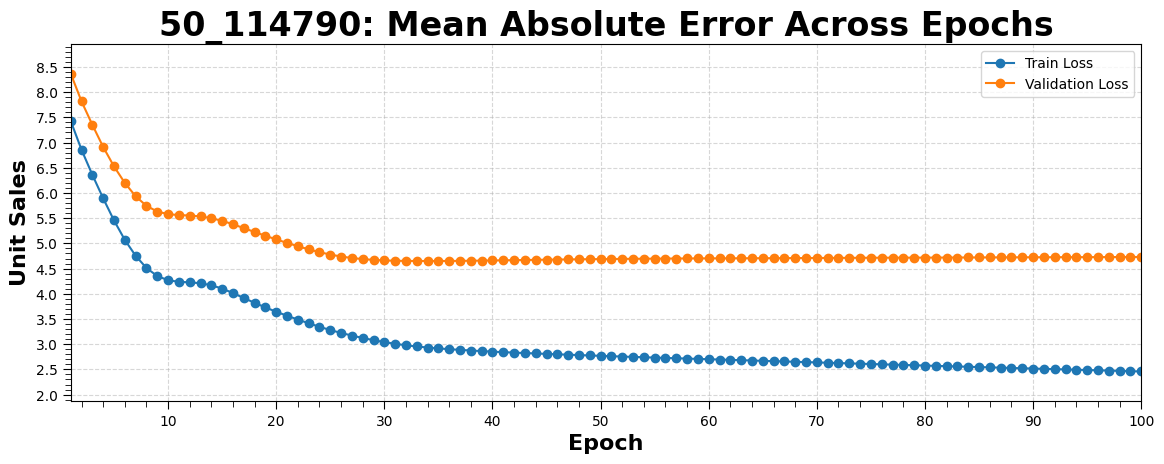

In [34]:
sid = "50_114790"
title = f"{sid}: Mean Absolute Error Across Epochs"
plot_loss_per_sid(hist_df, title=title, 
                  sid=sid, fn=f"../output/figures/loss_curves_mae_{sid}_{today_str}.tiff", 
                  train_col="train_mae", test_col="test_mae", y_label="Unit Sales")